# ECE 3100 Final Project 
Joseph Whelan (jfw255) and Kenneth Trinh (klt45)


In [9]:
import numpy as np
from matplotlib import pyplot as plt

## Question 1-(a)
Let (-) represent the event that a sample of n people test negative. <br>
Let (+) represent the event that a sample of n people test positive. <br>
Given that $p$ is the infection rate: <br>



\begin{aligned}
Pr(-) &= (1-p)^{n} \\
Pr(+) &= 1 - (1-p)^{n} \\
\\
{E[D_{n}]} &= E[D_{n} | + ] Pr(+) + E[D_{n}] Pr(-) \\
                &= [ (n+1)(1-(1-p)^n ] + [1 (1-p)^n]\\
                &= (n+1)(1-(1-p)^n)  +  (1-p)^n  \\
                \mbox{for n>1}
\end{aligned}

${E[D_{n}]}$ as a function of p ∈ (0, 0.4) for n = 100 <br>
${E[D_{n}]}$ as a function of n ∈ [10 − 200] for p = 0.01

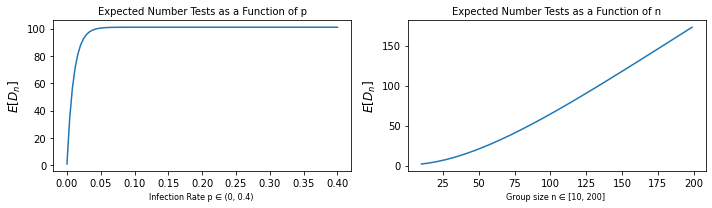

In [16]:
def q1_a():
    q = lambda p,n: (1-p)**n
    E = lambda p, n: 1 if n==1 else (n + 1) * (1 - q(p, n)) +  q(p, n)
    p = np.linspace(0, 0.4, 100)
    E_p = [E(i, 100) for i in p] #E(p=p, n=100)
    n = np.arange(10, 200)
    E_n = [E(0.01, i) for i in n]#E(p=0.01, n=n)
    fig , axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
    axs[0].plot(p, E_p)
    axs[1].plot(n, E_n)
    axs[0].set_xlabel('Infection Rate p ∈ (0, 0.4) ', fontsize=8)
    axs[1].set_xlabel('Group size n ∈ [10, 200] ', fontsize=8)
    axs[0].set_ylabel(r'$E[D_{n}]$', fontsize=12)
    axs[1].set_ylabel(r'$E[D_{n}]$', fontsize=12)
    axs[0].set_title("Expected Number Tests as a Function of p", fontsize=10)
    axs[1].set_title("Expected Number Tests as a Function of n", fontsize=10)
    fig.tight_layout()
    plt.show()

q1_a()

## Question 1-(b)
η<sub>p</sub> (n) = $\frac{n}{E[D_{n}]}$ <br>

$ n^{*}=\underset{   n = 1,2,3...}{\operatorname{arg max}} \frac{n}{E[D_{n}]}$

Numerical solution for finding optimal group size (n*) as a function of p ∈ (0, 0.4)


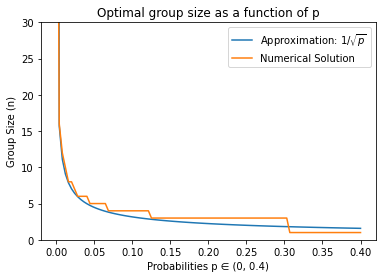

In [35]:
def q1_b():
    q = lambda p,n: (1-p)**n
    E = lambda p, n: 1 if n==1 else (n + 1) * (1 - q(p, n)) +  q(p, n)
    eta = lambda p, n: n / np.array( [E(p, i) for i in n ] )
    n_star = lambda p, n: np.argmax( eta(p, n) ) + 1 #p is scalar, n is vector
    n = np.arange(1, 100)
    prob = np.linspace(0.00001, 0.4, 100)
    opt = [n_star(p,n) for p in prob ]
    plt.ylim([0,30])
    plt.plot(prob, 1/np.sqrt(prob), label=r'Approximation: 1/$\sqrt{p}$')
    plt.plot(prob, opt, label='Numerical Solution')
    plt.title("Optimal group size as a function of p")
    plt.xlabel("Probabilities p ∈ (0, 0.4)")
    plt.ylabel("Group Size (n)")
    plt.legend()
    plt.show()
    
q1_b()

## Question 1-(c)

Dorfman testing simulation with optimal group size n* for N = 10,000 and p = 0.01, 0.04, 0.07, 0.1

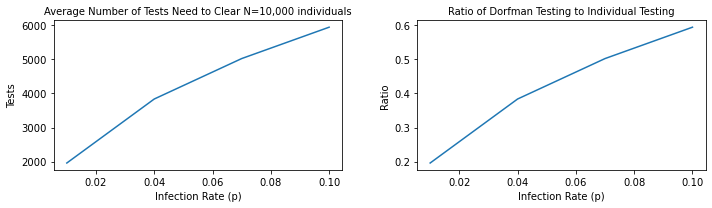

In [42]:
def q1_c(plot=True):
    N = 10000
    probs = [0.01, 0.04, 0.07, 0.1] #0.14, 0.17, 0.2]
    q = lambda p,n: (1-p)**n
    E = lambda p, n: 1 if n==1 else (n + 1) * (1 - q(p, n)) +  q(p, n)
    eta = lambda p, n: n / np.array( [E(p, i) for i in n ] )
    n_star = lambda p, n: np.argmax( eta(p, n) ) + 1 #p is scalar, n is vector
    n = np.arange(1, 100)
    opt = [n_star(p,n) for p in probs]
    if not plot:
        return opt
    def simulate(p, group_size):
        """
        Simulation: split into optimal group size; test each group
        (number of groups is lower bound for num_tests);
        for each infected group, increment num_tests by group size

        outputs the number of tests required to clear population
        """
        update = 0 if N % group_size ==0 else group_size - (N%group_size) #account for uneven groups
        population = np.random.choice(2, size=N+update, p=[1-p, p]) #1 if infected, 0 if not
        #sanity check: p~ np.where(population)[0].shape[0]/10000
        grouped = population.reshape(-1, group_size) #dimension: groups x group_size
        if N % group_size != 0: grouped[-1][-update:] = [0] * update # the extra individuals count as uninfected
        return grouped.shape[0] + group_size * np.sum( grouped.any(axis=1) ) #num_tests = number of groups +  group_size*groups with infected

    average_test = [ np.average( [simulate(p, group_size) for _ in range(1000)] ) for p, group_size in zip(probs, opt) ]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
    axes[0].plot(probs, average_test)
    axes[1].plot(probs, np.array(average_test)/10000)
    axes[0].set_title('Average Number of Tests Need to Clear N=10,000 individuals', fontsize=10)
    axes[1].set_title('Ratio of Dorfman Testing to Individual Testing', fontsize=10)
    for i in range(2):
        axes[i].set_xlabel('Infection Rate (p)')
        axes[i].set_ylabel('Tests' if i==0 else 'Ratio' )
    fig.tight_layout()
    plt.show()

q1_c()

## Question 1-(d)

Comparison between individual and dorfman testing for N = 10,000 people. Testing capacity with a maximum of 500 tests each day.

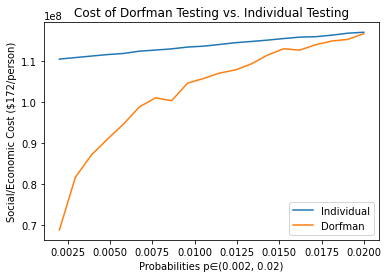

In [38]:
class Person:
    """
    Person class built for vector operations (overrides subtraction, multiplication, and eq operators)
    infected: a bool to indicated whether person is sick or not, used to update other attributes if not specified
    recovery: a timer integer value to indicate remaining recovery days, updated by the subtraction (-) operator
    need_test: another timer integer value where 1 indicates the person needs a test, and
    values >1 indicates person does not need test yet (but will in num days); min value 1
    """
    def __init__(self, infected, recovery=None, needs_test=None):
        self.infected = True if infected else False
        self.recovery = recovery if recovery!=None else 21 if infected else 0
        self.needs_test = needs_test if needs_test!=None else 1 #everyone starts out needing a test
    def __sub__(self, day):
        """
        Decrements recovery days if sick
        Example:
        >>> x = Person(1)
        >>> x
        (I:True R:21 NT:0)
        >>> x - 1 # decrements recovery and needs_test timers; modifies by reference
        >>> x
        (I:True R:20 NT:0)
        """
        self.recovery = max(self.recovery - day, 0)
        #if self.needs_test > 0:
        self.needs_test = max(self.needs_test - day, 1)
    def __mul__(self, new_infection):
        """
        Updates every day upon multiplication with randomized new infection rate (only
        applies if not already infected)
        Example:
        >>> x = Person(0)
        >>> x
        (I:False R:0 NT:0)
        >>> x * 1 # gives person infected attributes; modifies by reference
        >>> x
        (I:True R:21 NT:0)
        """
        if not self.infected and new_infection:
            self.infected = True
            self.recovery = 21
            
    def __eq__(self, other):
        """
        Used to find who needs a test
        Example:
        >>> Person(1, 0, 1) == 1
        True
        """
        return self.needs_test == other
    def __lt__(self, other):
        """
        Used to identify those infected (for group testing)
        Example:
        >>> Person(1) < 1
        True
        """
        return self.infected == other
    def __and__(self, other):
        """
        Used to identify those infected, recovering, but don't immediately need a test (tested already, so incapacitated)
        """
        return self.infected and self.recovery > 0 and self.needs_test > 1 and bool(other)
    def __repr__(self):
        """For debugging """
        return f'(I:{self.infected} R:{self.recovery} NT:{self.needs_test})'
    def clear(self):
        self.infected = False
        self.recovery = 0
        self.needs_test = (7 + 1)

def t(p): #if infected is True, can only clear if done recovering
    if (p.infected and p.recovery > 0 and p.needs_test == 1):  #still recovering and needs test -> set needs_test timer
        p.needs_test = p.recovery + 1
    if (p.infected and p.recovery > 0 and p.needs_test > 1): #still recovering and doesn't need test immediately -> can't clear
        pass
    if (p.infected and p.recovery == 0 and p.needs_test == 1): #done recovering, needs test -> clear
        p.infected = False
        p.needs_test = (7+1)
    if (p.infected and p.recovery == 0 and p.needs_test > 1): # done recovering but doesn't need test (not possible since needs_test <= recovery + 1)
        pass
    #if infected is False, recovery always 0, and can clear iff needs test
    if ( (not p.infected) and p.recovery > 0 and p.needs_test == 1):
        pass
    if ( (not p.infected) and p.recovery > 0 and p.needs_test > 1):
        pass
    if ( (not p.infected) and p.recovery == 0 and p.needs_test == 1): #needs test immediately
        p.needs_test = (7+1)
    if ( (not p.infected) and p.recovery == 0 and p.needs_test > 1): #doesn't need test immediately
        pass

test = np.vectorize(t)

def individual(p=0.002):
    N =  10000
    group_size = int( 1/np.sqrt(p) )
    
    initialize = np.vectorize(lambda p: Person(p))
    population = initialize( np.random.choice(2, size=N, p=[1-p, p]) )

    q = np.array([], dtype='int64') #queue of indices of people to be tested

    total = 0
    for day in range(90):
        
        #each person is infected with a probability of p every day, independent of other days
        population * np.random.choice(2, size=N, p=[1-p, p])
        
        #the people that need a test are exactly those that have self.needs_test == 1
        q = np.where(population == 1 )[0]  

        test( population[ q[:500] ] )

        population - 1 #decrement recovery days and test days remaining (before returning to work)

        #the confined population is both those that need a test or
        #those that are infected, recovering, but don't need a test immediately
        #print( f'Individual Confined: { np.union1d( np.where(population ==1), np.where(population & 1) ).size}'  )
        total +=  np.union1d( np.where(population ==1), np.where(population & 1) ).size

    return total * 172


def dorfman(p=0.002):
    N =  10000
    group_size = int( 1/np.sqrt(p) )
    
    #if N is not divisible by the group size then we pad the population
    #with extra individuals 
    update = 0 if N % group_size ==0 else group_size - (N%group_size)

    initialize = np.vectorize(lambda p: Person(p))
    population = initialize( np.random.choice(2, size=N+update, p=[1-p, p]) )
    grouped = population.reshape(-1, group_size) #dimension: groups x group_size

    group_clear = np.vectorize( Person.clear )

    # the extra individuals at the end don't count
    if N % group_size != 0:
        grouped[-1][-update:] = [Person(0, 0, 0)] * update 

    total = 0
    for day in range(90):
        
        #each person is infected with a probability of p every day, independent of other days
        grouped * np.random.choice(2, size=N+update, p=[1-p, p]).reshape(-1, group_size)
        
        # find which groups negative and put at the front of queue 
        # The idea is to exhaust max tests on these groups first - this is the
        # most optimal upper bound, as you wouldn't know which groups infected 
        # in real life until you test
        neg_groups = grouped[np.where ( np.all(grouped<0, axis = 1) )[0]] #all not infected
        pos_groups = grouped[np.where ( np.any(grouped<1, axis = 1) )[0]] #any infected
        grouped = np.vstack( (neg_groups, pos_groups) )
        MAX_TESTS = 500
        while MAX_TESTS > max(group_size, 0):
            if np.all( grouped[0] < 0 ): #if all are not infected, clear the group (counts as one test, so we decrement MAX_TESTS each iteration)
                group_clear(grouped[0])
            else:
                test(grouped[0])
                MAX_TESTS -= grouped.shape[1] #decrement by group size
            grouped = np.vstack( (grouped[1:], grouped[0])  ) #push the group just tested to back
            MAX_TESTS -= 1
    
        grouped - 1 #decrement recovery days and test days remaining (before returning to work)
    
        #the confined population is both those that need a test or
        #those that are infected, recovering, but don't need a test immediately
        #count each unique person indexed by tuple tuple (i,j)
        Confined  = set(zip(np.where(grouped == 1)[0], np.where(grouped == 1)[1]))
        Confined.update( set(zip(np.where(grouped & 1)[0], np.where(grouped & 1)[1]))  )
        #print( f'Dorfman Confined: {len(Confined)}'  )
        total += len(Confined)
    return total * 172

def q1_d():
    probs = np.linspace(0.002, 0.02, 20)
    individual_cost = [individual(p) for p in probs]
    dorfman_cost = [dorfman(p) for p in probs]
    plt.plot(probs, individual_cost, label='Individual')
    plt.plot(probs, dorfman_cost, label='Dorfman')
    plt.xlabel("Probabilities p∈(0.002, 0.02)")
    plt.ylabel("Social/Economic Cost ($172/person)")
    plt.title("Cost of Dorfman Testing vs. Individual Testing")
    plt.legend()
    plt.show()

q1_d()

## Question 2 - (c)
Let ${B_{n}}$ denote the number of tests required to identify all (if any) infected persons with an initial group size n under the binary splitting strategy.

Let $q = 1-p$, then our events defined from 1a simplify to: <br>
$Pr(-) = q^n$ <br>
$Pr(+) = 1-q^n$ <br>

Let's define a new event,<br> 
$C_{n}$: the number of tests required to identify all infected individual in a group of size n given that at least one of these n persons is infected.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; n (positive)
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
n (positive) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; / &nbsp;&nbsp;&nbsp;\ 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; / &nbsp;&nbsp;&nbsp;\ <br>
 n/2 (positive)
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
 n/2 (negative) <br>

For the left case our expectation becomes ${E[1 + B_{n/2} + C_{n/2}]}$ <br>
For the right case our expectation becomes ${E[1 + C_{n/2}]}$ <br>


${E[C_{n}]} = {E[B_{n} | +]}  = {E[B_{n} | +, Left \: + ]}\: Pr(Left \: + | +) + {E[B_{n} | +, Left \: - ]}\: Pr(Left \: - | +) $  <br>

Using $p_{+}$ and $p_{-}$ for ease of notation: <br>
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; = E[1 + B_{n/2} + C_{n/2}] \:p_{+} + E[1 + C_{n/2}]\:p_{-} $ <br>

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; = ( p_{+} + p_{-} ) E[1 + C_{n/2}] + 
 p_{+} E[B_{n/2}] $ <br>
 
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; = 1 + E[C_{n/2}] + p_{+} E[B_{n/2}] $ <br>

We calculate $p_{+}$ using Bayes Theorem:

$ p_{+} = Pr(Left \: + | +) = \frac{Pr(+ |Left \: + ) Pr(Left \: +)} {Pr(+)} = \frac{1 *  (1-q^{n/2})} {1-q^{n}} = \frac{1} {1+q^{n/2}}$

$ E[B_{n}] $ stays the same as before, but now we use $ E[C_{n}] $ in place of n. Now, we can write our recursive equations:

$ E[B_{n}] = (E[C_{n}]+1)(1-q^{n}) + q^{n} $ <br>
$ E[C_{n}] = 1 + E[C_{n/2}] + \frac{E[B_{n/2}]} {1+q^{n/2}} $ <br>
Base cases: $ E[B_{1}] = 1, E[C_{1}] = 0 $




## Question 2 -(a)

The expression for $ E[B_{2}] $ can be obtained by substituting n = 2 into the recursive equations obtained from part 2c, and then substituting the terms of $ E[C_{2}] $ into  $ E[B_{2}] $

$ E[B_{2}] = (E[C_{2}]+1)(1-q^{2}) + q^{2} $ <br>
$\;\;\;\;\;\;\;\;\; =  ( [1+ E[C_{2/2}] + \frac{E[B_{2/2}]} {1+q^{2/2}}] +1)(1-q^{2}) + q^{2} $ <br>
$\;\;\;\;\;\;\;\;\; =  ( 2 + E[C_{1}] + \frac{E[B_{1}]} {1+q^{1}} )(1-q^{2}) + q^{2} $ <br>
$\;\;\;\;\;\;\;\;\; =  ( 2 + \frac{1} {1+q} )(1-q^{2}) + q^{2} $ <br>
$\;\;\;\;\;\;\;\;\; =  ( 2 + \frac{1} {1+ (1-p) } )(1-(1-p)^{2}) + (1-p)^{2} $ <br>
$\;\;\;\;\;\;\;\;\; =  ( 2 + \frac{1} {2-p } )(1-(1-p)^{2}) + (1-p)^{2} $                

## Question 2 -(b)
The expression for $ E[B_{2}] $ can be obtained by substituting n = 4 into the recursive equations obtained from part 2c.  

$ E[C_{4}] = 1 + E[C_{4/2}] + \frac{E[B_{4/2}]} {1+q^{4/2}} $ <br>
$\;\;\;\;\;\;\;\;\; =  1 + E[C_{2}] + \frac{E[B_{2}]} {1+q^{2}} $ <br>

$ E[C_{2}] = [1+ E[C_{2/2}] + \frac{E[B_{2/2}]} {1+q^{2/2}}] $ <br>
$\;\;\;\;\;\;\;\;\; =  1+ E[C_{1}] + \frac{E[B_{1}]} {1+q} $ <br>
$\;\;\;\;\;\;\;\;\; =  1+ \frac{1} {1+q} $ <br>

$ E[B_{4}] = (E[C_{4}]+1)(1-q^{4}) + q^{4} $ <br>
$\;\;\;\;\;\;\;\;\; =  ([ 1 + E[C_{2}] + \frac{E[B_{2}]} {1+q^{2}}] +1)(1-q^{4}) + q^{4} $ <br>
$\;\;\;\;\;\;\;\;\; =  ([ 2 + E[C_{2}] + \frac{E[B_{2}]} {1+q^{2}}] )(1-q^{4}) + q^{4} $ <br>
$\;\;\;\;\;\;\;\;\; =  ([ 2 + 1+ \frac{1} {1+q} + \frac{E[B_{2}]} {1+q^{2}}] )(1-q^{4}) + q^{4} $ <br>
$\;\;\;\;\;\;\;\;\; =  ([ 3 + \frac{1} {1+q} + \frac{E[B_{2}]} {1+q^{2}}] )(1-q^{4}) + q^{4} $ <br>

where $q = 1-p$

## Question 2 -(d)

η<sub>p</sub> (n) = $\frac{n}{E[B_{n}]}$ <br>

$ n^{*}=\underset{   n = 1,2,3...}{\operatorname{arg max}} \frac{n}{E[B_{n}]}$

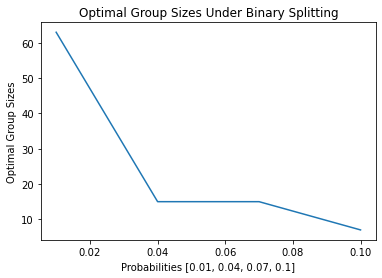

Optimal Group sizes for probabilities [0.01, 0.04, 0.07, 0.1]: [63, 15, 15, 7]


In [51]:
def q2_d(plot=True):
    probs = [0.01, 0.04, 0.07, 0.1]
    q = lambda p,n: (1-p)**n
    B = lambda p,n: 1 if n == 1 else (1 - q(p, n))*(1 + C(p,n) ) + q(p, n)
    C = lambda p,n: 0 if n == 1 else ( B(p, n//2)/( 1+ q(p, n//2) ) ) + 1 + C(p,n//2)
    eta = lambda p, n: n / np.array( [B(p,i) for i in n] ) #B is a scalar function so use list comp
    n_star = lambda p, n: np.argmax( eta(p, n) ) + 1
    n = np.arange(1, 100)
    opt = [n_star(p,n) for p in probs]
    if not plot:
        return opt
    plt.plot(probs, opt)
    plt.title("Optimal Group Sizes Under Binary Splitting")
    plt.xlabel("Probabilities [0.01, 0.04, 0.07, 0.1]")
    plt.ylabel('Optimal Group Sizes')
    plt.show()

q2_d()
print(f'Optimal Group sizes for probabilities [0.01, 0.04, 0.07, 0.1]: {q2_d(False)}')

## Question 2 -(e)


Improvement {0.01: (1956.522795667095, 839.1668500090009), 0.04: (3839.1557479587855, 2238.8722003147263), 0.07: (5020.479900000002, 3172.8469662058965), 0.1: (5940.0, 3921.305009433709)}


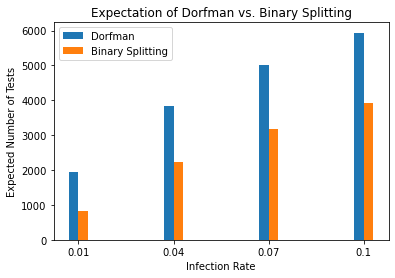

In [63]:
def q2_e():
    N = 10000
    probs = [0.01, 0.04, 0.07, 0.1]
    q = lambda p,n: (1-p)**n

    D = lambda p, n: (n + 1) * (1 - q(p, n)) +  q(p, n)# expectation of dorfamn
    #D = lambda p, n: 0 if n==0 else n*(1/n + 1 - ((1-p)**n )) # expectation of dorfamn

    B = lambda p,n: 1 if n == 1 else (1 - q(p, n))*(1 + C(p,n) )+ q(p, n) #expectation of binary splitting
    C = lambda p,n: 0 if n == 1 else ( B(p, n//2)/( 1+ q(p, n//2) ) ) + 1 + C(p,n//2)

    Expectation = lambda f, group_size, p: f(p, group_size) * (N//group_size) + f(p, N%group_size)

    #I coulda done this all in one line but that's a dick move for the reader
    compare = {p: -1 for p in probs}
    for p, dorf_group, binary_group in zip(probs, q1_c(False), q2_d(False) ): #[10, 5, 3, 3] [62, 14, 14, 6]
        dorfman = Expectation(D, dorf_group, p)
        binary = Expectation(B, binary_group, p)
        compare[p] = (dorfman, binary)
    
    a = np.array( [[compare[p][0],compare[p][1]] for p in probs] )
    for i, value in zip( np.linspace(-0.05, 0.05, 2), a.T):
        plt.bar(np.arange(4)+i, value, width = 0.1)
    plt.xticks(np.arange(4), probs )
    plt.legend(['Dorfman', 'Binary Splitting'])
    plt.title('Expectation of Dorfman vs. Binary Splitting')

    plt.xlabel('Infection Rate')
    plt.ylabel('Expected Number of Tests')
    print(f'Improvement {compare}')
    plt.show()

q2_e()